### Problem Statement:

**This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.**


### Import Required Libarary

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle
import datetime
from scipy.stats import zscore
pd.set_option('display.max_columns', None) # For display maximum columns
from sklearn.preprocessing import StandardScaler,OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Reading Data

In [2]:
df = pd.read_csv(r"C:\Users\Kushal Arya\Desktop\csv file\temperature.csv")
df.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,30-06-2013,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,30-06-2013,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,30-06-2013,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,0.0,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,30-06-2013,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.0,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,30-06-2013,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.0,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


#### Columns Information:

1. station - used weather station number: 1 to 25
2. Date - Present day: yyyy-mm-dd ('2013-06-30' to '2017-08-30')
3. Present_Tmax - Maximum air temperature between 0 and 21 h on the present day (Â°C): 20 to 37.6
4. Present_Tmin - Minimum air temperature between 0 and 21 h on the present day (Â°C): 11.3 to 29.9
5. LDAPS_RHmin - LDAPS model forecast of next-day minimum relative humidity (%): 19.8 to 98.5
6. LDAPS_RHmax - LDAPS model forecast of next-day maximum relative humidity (%): 58.9 to 100
7. LDAPS_Tmax_lapse - LDAPS model forecast of next-day maximum air temperature applied lapse rate (Â°C): 17.6 to 38.5
8. LDAPS_Tmin_lapse - LDAPS model forecast of next-day minimum air temperature applied lapse rate (Â°C): 14.3 to 29.6
9. LDAPS_WS - LDAPS model forecast of next-day average wind speed (m/s): 2.9 to 21.9
10. LDAPS_LH - LDAPS model forecast of next-day average latent heat flux (W/m2): -13.6 to 213.4
11. LDAPS_CC1 - LDAPS model forecast of next-day 1st 6-hour split average cloud cover (0-5 h) (%): 0 to 0.97
12. LDAPS_CC2 - LDAPS model forecast of next-day 2nd 6-hour split average cloud cover (6-11 h) (%): 0 to 0.97
13. LDAPS_CC3 - LDAPS model forecast of next-day 3rd 6-hour split average cloud cover (12-17 h) (%): 0 to 0.98
14. LDAPS_CC4 - LDAPS model forecast of next-day 4th 6-hour split average cloud cover (18-23 h) (%): 0 to 0.97
15. LDAPS_PPT1 - LDAPS model forecast of next-day 1st 6-hour split average precipitation (0-5 h) (%): 0 to 23.7
16. LDAPS_PPT2 - LDAPS model forecast of next-day 2nd 6-hour split average precipitation (6-11 h) (%): 0 to 21.6
17. LDAPS_PPT3 - LDAPS model forecast of next-day 3rd 6-hour split average precipitation (12-17 h) (%): 0 to 15.8
18. LDAPS_PPT4 - LDAPS model forecast of next-day 4th 6-hour split average precipitation (18-23 h) (%): 0 to 16.7
19. lat - Latitude (Â°): 37.456 to 37.645
20. lon - Longitude (Â°): 126.826 to 127.135
21. DEM - Elevation (m): 12.4 to 212.3
22. Slope - Slope (Â°): 0.1 to 5.2
23. Solar radiation - Daily incoming solar radiation (wh/m2): 4329.5 to 5992.9
24. Next_Tmax - The next-day maximum air temperature (Â°C): 17.4 to 38.9
25. Next_Tmin - The next-day minimum air temperature (Â°C): 11.3 to 29.8T

### Check no of row and column

In [3]:
print('No of Rows and Columns ----->', df.shape )

No of Rows and Columns -----> (7752, 25)


### Checking for Null values

In [4]:
print('================================\n')
print(df.isnull().sum())
print('\n================================')


station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64



#### There is null value

### Information about dataset

In [5]:
print('==================================================\n')
print(df.info())
print('====================================================')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64

### Fill NaN

In [6]:
df = df.apply(lambda x:x.fillna(x.mean())if x.dtype == 'float64' else x.fillna(x.value_counts().index[0]))

In [7]:
print('================================\n')
print(df.isnull().sum())
print('\n================================')


station             0
Date                0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64



#### There is no null value left

### Statistics of Data

In [8]:
df.describe()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
count,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000
mean,13.000000,29.768211,23.225059,56.759372,88.374804,29.613447,23.512589,7.097875,62.505019,0.368774,0.356080,0.318404,0.299191,0.591995,0.485003,0.278200,0.269407,37.544722,126.991397,61.867972,1.257048,5341.502803,30.274887,22.932220
std,7.210637,2.956557,2.403036,14.596973,7.157124,2.932898,2.333973,2.173245,33.567001,0.261185,0.256810,0.249148,0.253114,1.936331,1.754258,1.156174,1.200364,0.050352,0.079435,54.279780,1.370444,429.158867,3.122557,2.483276
min,1.000000,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098475,4329.520508,17.400000,11.300000
25%,7.000000,27.800000,21.700000,46.046162,84.316923,27.693091,22.114651,5.686487,37.532764,0.148321,0.142328,0.103100,0.082741,0.000000,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,4999.018555,28.200000,21.400000
50%,13.000000,29.900000,23.400000,55.313244,89.699505,29.662273,23.735942,6.563068,57.310630,0.320110,0.315667,0.265264,0.232354,0.000000,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5436.345215,30.500000,23.100000
75%,19.000000,32.000000,24.900000,67.038254,93.704500,31.683819,25.134000,8.007471,83.904586,0.571696,0.554963,0.494007,0.497230,0.067593,0.024276,0.009697,0.000693,37.577600,127.042000,59.832400,1.767800,5728.316406,32.600000,24.600000
max,25.000000,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,0.968353,0.983789,0.974710,23.701544,21.621661,15.841235,16.655469,37.645000,127.135000,212.335000,5.178230,5992.895996,38.900000,29.800000


#### Outliers are present in our data set

### Features Engineering

### Date column

In [9]:
df['Date'].value_counts()

02-08-2016    27
05-07-2016    25
20-08-2014    25
31-07-2017    25
08-07-2014    25
              ..
24-07-2015    25
05-08-2015    25
08-08-2014    25
17-07-2013    25
03-08-2014    25
Name: Date, Length: 310, dtype: int64

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

### Add Year Column

In [11]:
df['Years'] = df['Date'].dt.year
df['Years'] = df['Years'].astype('int')
df.head(2)

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Years
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,2013
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,2013


In [12]:
df['Years'].value_counts()

2016    1552
2013    1550
2017    1550
2014    1550
2015    1550
Name: Years, dtype: int64

In [13]:
df['Months'] = df['Date'].dt.month
df['Months'] = df['Months'].astype('int')
df.head(2)

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Years,Months
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,2013,6
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,2013,6


### Join Years and Months

In [14]:
cols=["Years","Months"]
df['Years&Months'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
df.head(2)

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Years,Months,Years&Months
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,2013,6,2013-6
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,2013,6,2013-6


### Convert Date column into object

In [15]:
df['Date'] = df['Date'].astype('str')

### Analysis of data respect to next-day maximum temperatures

### Station column

In [16]:
df['station'].value_counts()

13.0    312
15.0    310
21.0    310
7.0     310
23.0    310
8.0     310
3.0     310
10.0    310
16.0    310
11.0    310
2.0     310
12.0    310
9.0     310
24.0    310
4.0     310
25.0    310
22.0    310
17.0    310
19.0    310
20.0    310
1.0     310
5.0     310
18.0    310
6.0     310
14.0    310
Name: station, dtype: int64

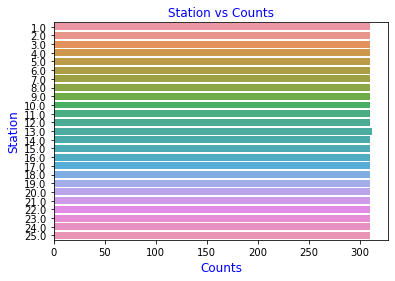

In [17]:
sns.countplot( y="station", data=df)
plt.ylabel('Station', c = 'b', fontsize = 12)
plt.xlabel('Counts', c = 'b', fontsize = 12)
plt.title('Station vs Counts', c = 'b', fontsize = 12)
plt.show()

#### Above plot shows station no and there counts

### Date column

In [18]:
df['Years&Months'].value_counts()

2014-7     525
2013-7     525
2017-7     525
2015-7     525
2016-7     525
2014-8     500
2017-8     500
2015-8     500
2013-8     500
2016-8     500
2015-6      75
2016-6      75
2013-6      75
2014-6      75
2017-6      75
2016-2      52
2014-3      50
2014-12     50
2013-4      50
2013-11     50
2013-9      50
2016-11     50
2015-9      50
2017-10     50
2017-12     50
2013-10     50
2017-9      50
2014-2      50
2013-2      50
2015-12     50
2016-1      50
2013-3      50
2016-9      50
2016-3      50
2015-4      50
2015-2      50
2017-11     50
2014-4      50
2013-5      50
2017-4      50
2015-10     50
2017-1      50
2014-9      50
2014-5      50
2014-10     50
2013-1      50
2014-1      50
2016-12     50
2016-10     50
2014-11     50
2015-1      50
2017-5      50
2017-3      50
2015-3      50
2017-2      50
2016-4      50
2013-12     50
2015-11     50
2016-5      50
2015-5      50
Name: Years&Months, dtype: int64

In [19]:
y = df.groupby('Years&Months')['Next_Tmax'].value_counts()
y

Years&Months  Next_Tmax
2013-1        28.200000    4
              27.100000    3
              29.700000    3
              26.800000    2
              27.300000    2
                          ..
2017-9        24.500000    1
              24.600000    1
              26.900000    1
              27.100000    1
              30.274887    1
Name: Next_Tmax, Length: 2758, dtype: int64

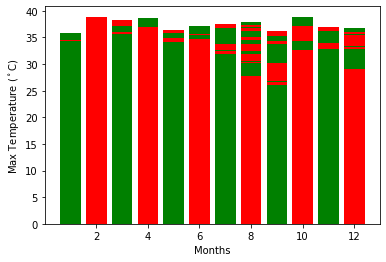

In [20]:
plt.bar(df['Months'],df['Next_Tmax'], color= ('g','r'))
plt.xlabel('Months')
plt.ylabel('Max Temperature ($^\circ$C)')
plt.show()

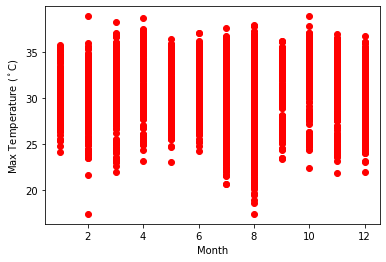

In [21]:
plt.figure()
plt.plot(df['Months'], df['Next_Tmax'], 'ro')
plt.xlabel('Month')
plt.ylabel('Max Temperature ($^\circ$C)')
plt.show()

#### Above both plot shows 8th Month higest disparity in Max Temperature

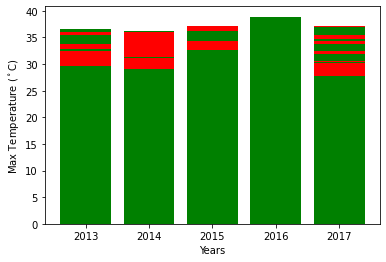

In [22]:
plt.bar( df['Years'],df['Next_Tmax'], color= ('r','g'))
plt.xlabel('Years')
plt.ylabel('Max Temperature ($^\circ$C)')
plt.show()

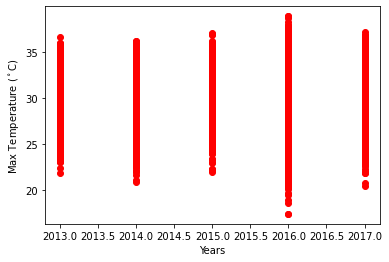

In [23]:
plt.figure()
plt.plot(df['Years'], df['Next_Tmax'], 'ro')
plt.xlabel('Years')
plt.ylabel('Max Temperature ($^\circ$C)')
plt.show()

#### Above both plot shows 2016 Year higest disparity in Max Temperature

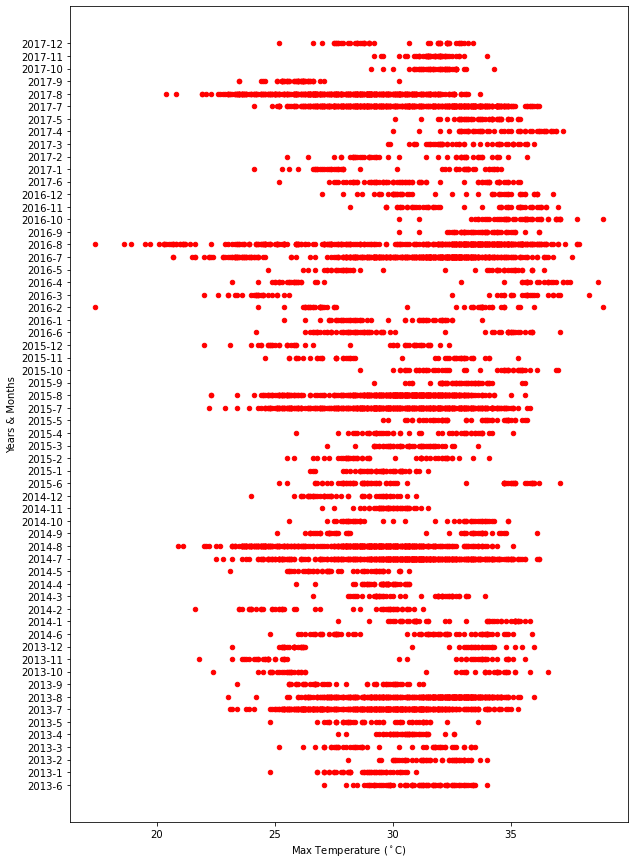

In [24]:
df.plot.scatter(x = 'Next_Tmax', y = 'Years&Months', figsize=(10,15), c = 'r')
plt.ylabel('Years & Months')
plt.xlabel('Max Temperature ($^\circ$C)')
plt.show()

#### Above plot shows 2016 year 8th month higest disparity in Max Temperature

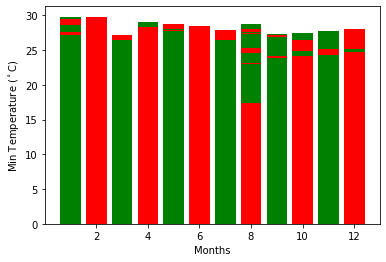

In [25]:
plt.bar(df['Months'],df['Next_Tmin'], color= ('g','r'))
plt.xlabel('Months')
plt.ylabel('Min Temperature ($^\circ$C)')
plt.show()

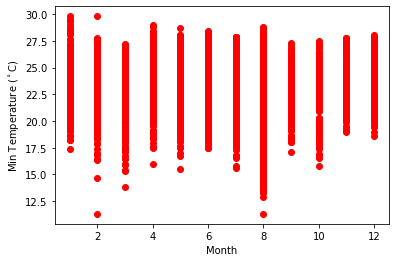

In [26]:
plt.figure()
plt.plot(df['Months'], df['Next_Tmin'], 'ro')
plt.xlabel('Month')
plt.ylabel('Min Temperature ($^\circ$C)')
plt.show()

#### Above both plot shows 3rd Month higest disparity in Min Temperature

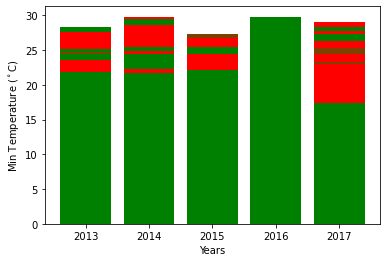

In [27]:
plt.bar( df['Years'],df['Next_Tmin'], color= ('r','g'))
plt.xlabel('Years')
plt.ylabel('Min Temperature ($^\circ$C)')
plt.show()

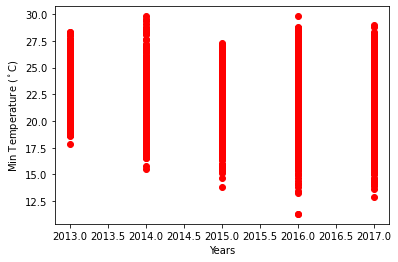

In [28]:
plt.figure()
plt.plot(df['Years'], df['Next_Tmin'], 'ro')
plt.xlabel('Years')
plt.ylabel('Min Temperature ($^\circ$C)')
plt.show()

#### Above both plot shows 2014 Year higest disparity in Min Temperature

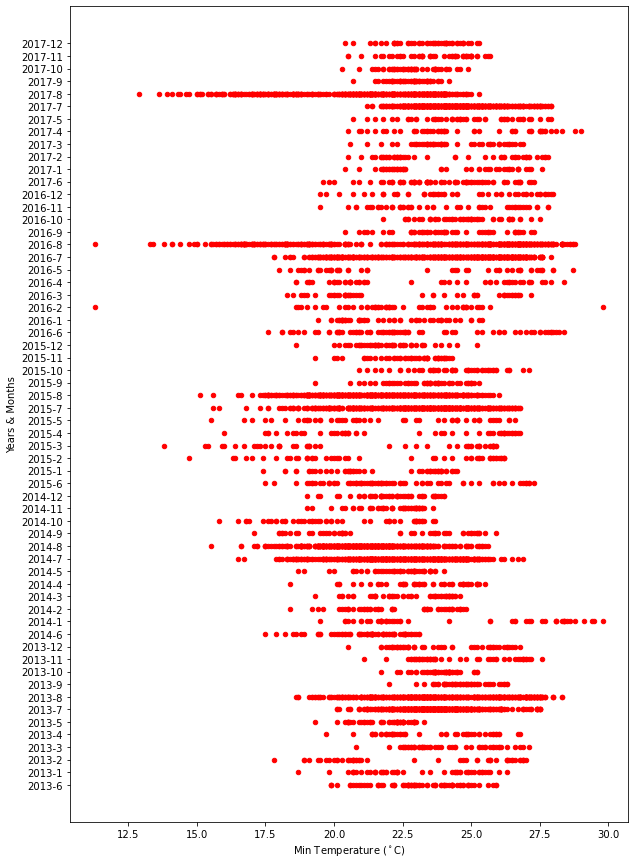

In [29]:
df.plot.scatter(x = 'Next_Tmin', y = 'Years&Months', figsize=(10,15), c = 'r')
plt.ylabel('Years & Months')
plt.xlabel('Min Temperature ($^\circ$C)')
plt.show()

#### Above plot shows 2014 year 3re month higest disparity in Min Temperature

### Co-ordinates

In [30]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
from geopandas import GeoDataFrame
from pyproj import CRS

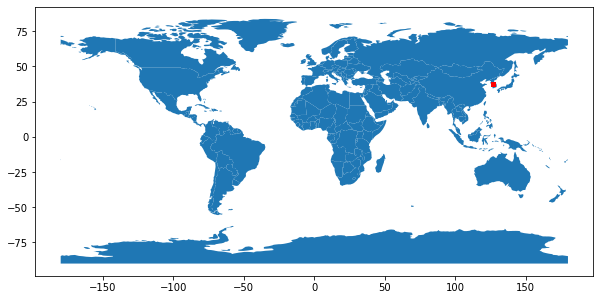

In [31]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

#### Above plot shows all cordinate belong to Korea

### Drop Unwanted column

In [32]:
df.drop('geometry', axis = 1, inplace = True)
df.head(2)

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Years,Months,Years&Months
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,2013,6,2013-6
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,2013,6,2013-6


In [33]:
df.shape # Here we check shape of remaining data after removal of column.

(7752, 28)

### Encoding Categorical Column

In [34]:
oe = OrdinalEncoder()
for i in df.columns:
    if df[i].dtypes == 'object':
        df[i] = oe.fit_transform(df[i].values.reshape(-1,1))
df.head(2)

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Years,Months,Years&Months
0,1.0,12.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,2013,6,8.0
1,2.0,12.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,2013,6,8.0


In [35]:
print('==================================================\n')
print(df.info())
print('====================================================')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7752 non-null   float64
 1   Date              7752 non-null   float64
 2   Present_Tmax      7752 non-null   float64
 3   Present_Tmin      7752 non-null   float64
 4   LDAPS_RHmin       7752 non-null   float64
 5   LDAPS_RHmax       7752 non-null   float64
 6   LDAPS_Tmax_lapse  7752 non-null   float64
 7   LDAPS_Tmin_lapse  7752 non-null   float64
 8   LDAPS_WS          7752 non-null   float64
 9   LDAPS_LH          7752 non-null   float64
 10  LDAPS_CC1         7752 non-null   float64
 11  LDAPS_CC2         7752 non-null   float64
 12  LDAPS_CC3         7752 non-null   float64
 13  LDAPS_CC4         7752 non-null   float64
 14  LDAPS_PPT1        7752 non-null   float64
 15  LDAPS_PPT2        7752 non-null   float64
 16  LDAPS_PPT3        7752 non-null   float64

### Data distribution 

---------------------
Distribution Plot :- 
---------------------


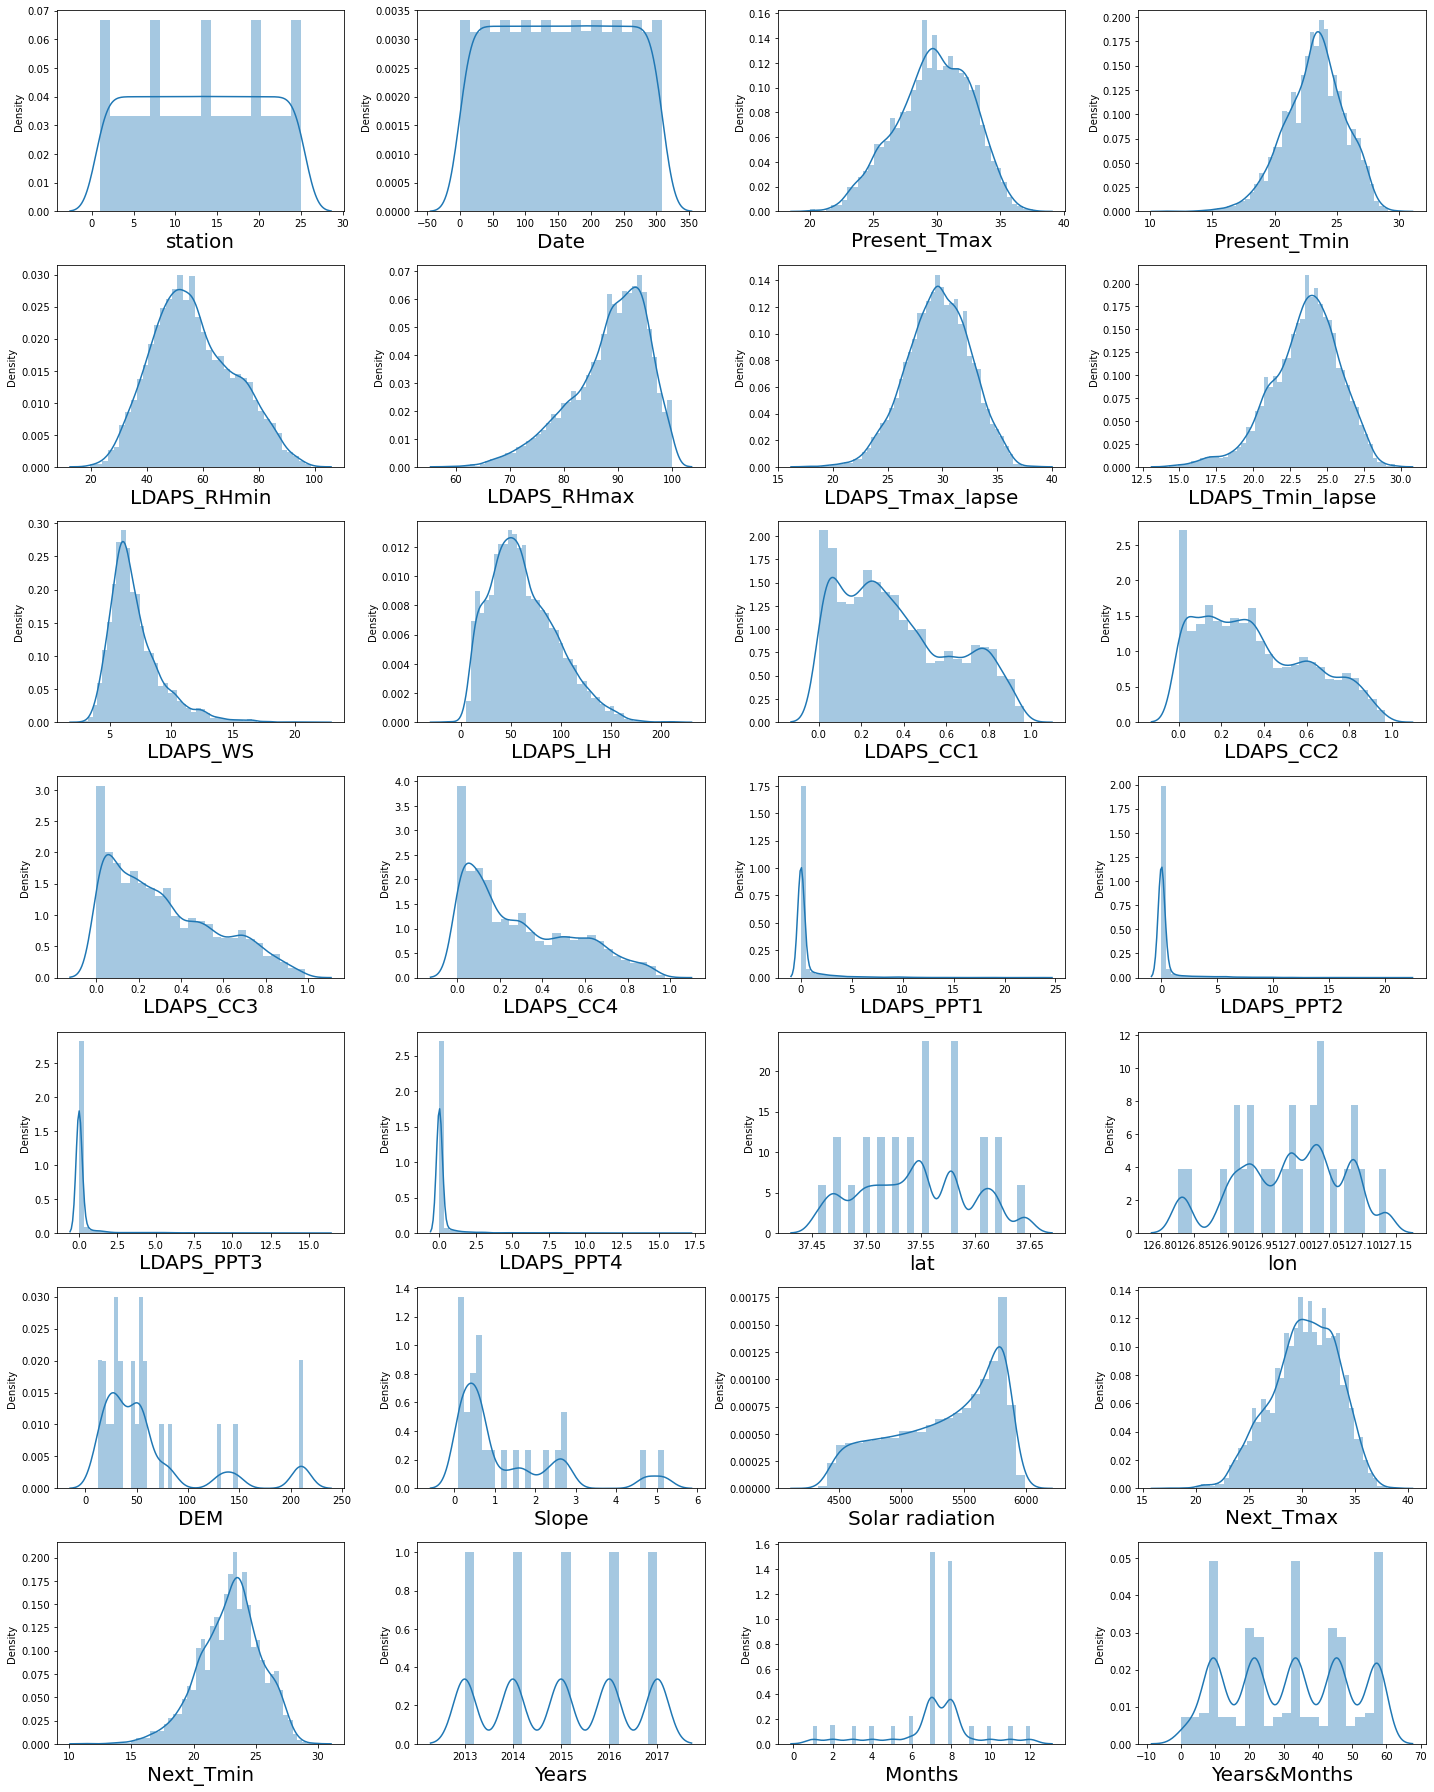

In [36]:
print('---------------------')
print('Distribution Plot :- ')
print('---------------------')
      
plt.figure(figsize = (20,25))
plotnumber = 1

for column in df:
    if plotnumber <=28:
        ax = plt.subplot(7,4, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column, fontsize = 20)
    plotnumber +=1
plt.tight_layout()

#### Data has skewed

### Check skweness

In [37]:
df.skew()

station             0.000000
Date               -0.000284
Present_Tmax       -0.264137
Present_Tmin       -0.367538
LDAPS_RHmin         0.300220
LDAPS_RHmax        -0.855015
LDAPS_Tmax_lapse   -0.227880
LDAPS_Tmin_lapse   -0.581763
LDAPS_WS            1.579236
LDAPS_LH            0.673757
LDAPS_CC1           0.459458
LDAPS_CC2           0.472350
LDAPS_CC3           0.640735
LDAPS_CC4           0.666482
LDAPS_PPT1          5.393821
LDAPS_PPT2          5.775355
LDAPS_PPT3          6.457129
LDAPS_PPT4          6.825464
lat                 0.087062
lon                -0.285213
DEM                 1.723257
Slope               1.563020
Solar radiation    -0.511210
Next_Tmax          -0.340200
Next_Tmin          -0.404447
Years              -0.000456
Months             -0.705185
Years&Months       -0.007382
dtype: float64

#### Skewness present in our dataset

-----------
Heat Map :-
-----------


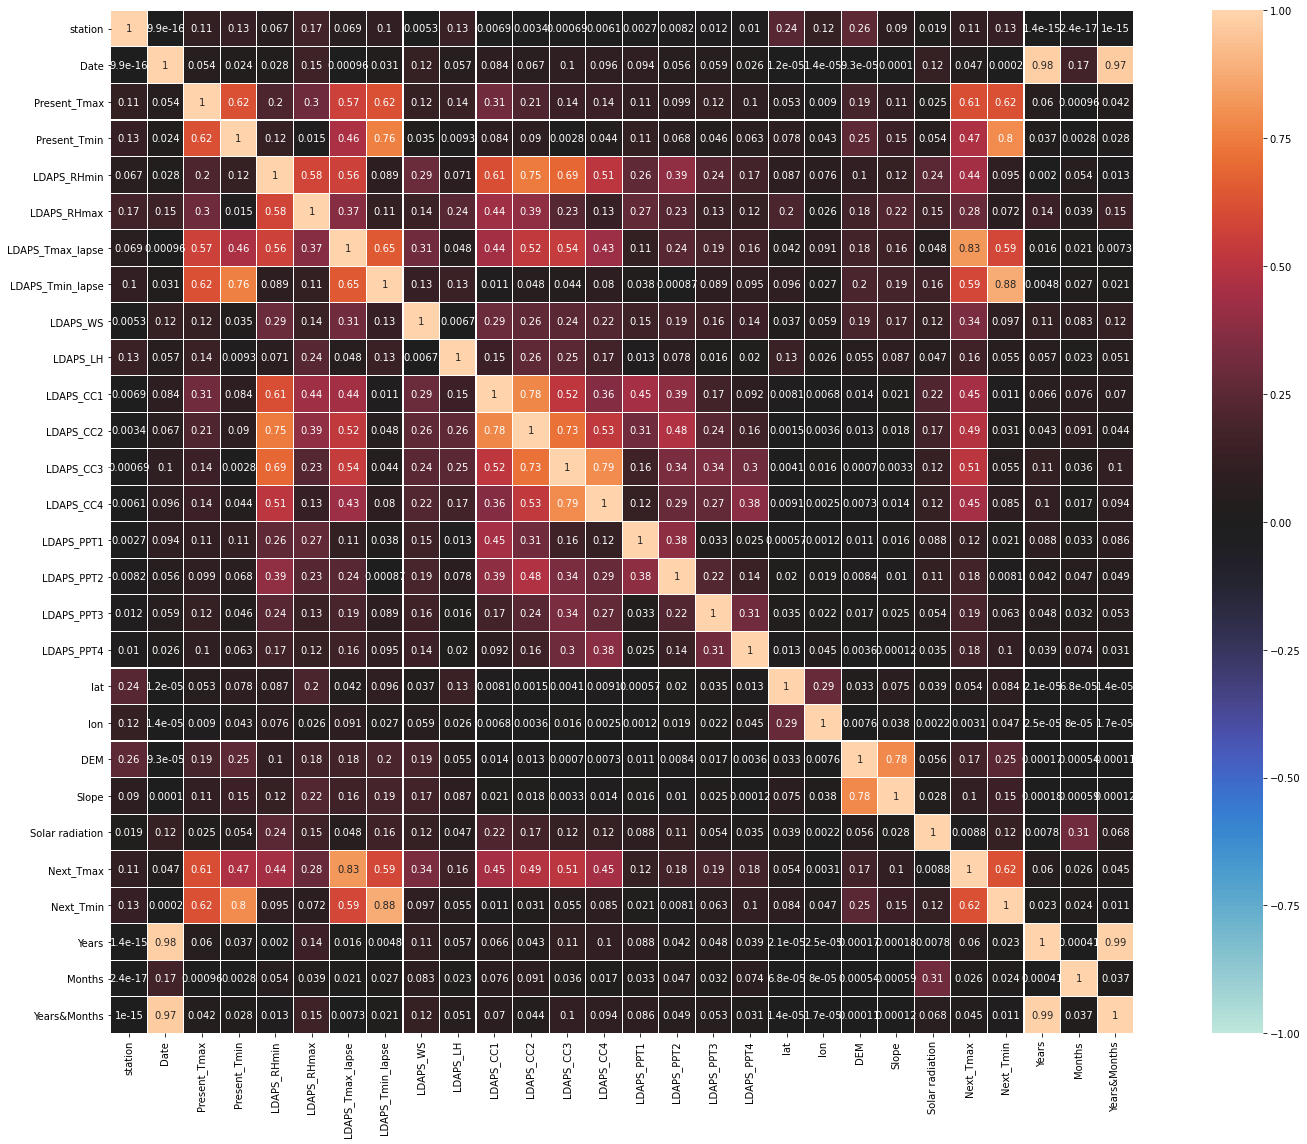

In [38]:
print('-----------')
print('Heat Map :-')
print('-----------')
df_corr = df.corr().abs()

plt.figure(figsize = (22,16))
sns.heatmap(df_corr, vmin = -1, annot = True, square = True, center = 0, fmt = '.2g', linewidths = .1)
plt.tight_layout()

#### Date and Years has highest corelation with label

### Checking Outliers

Box Plot :-


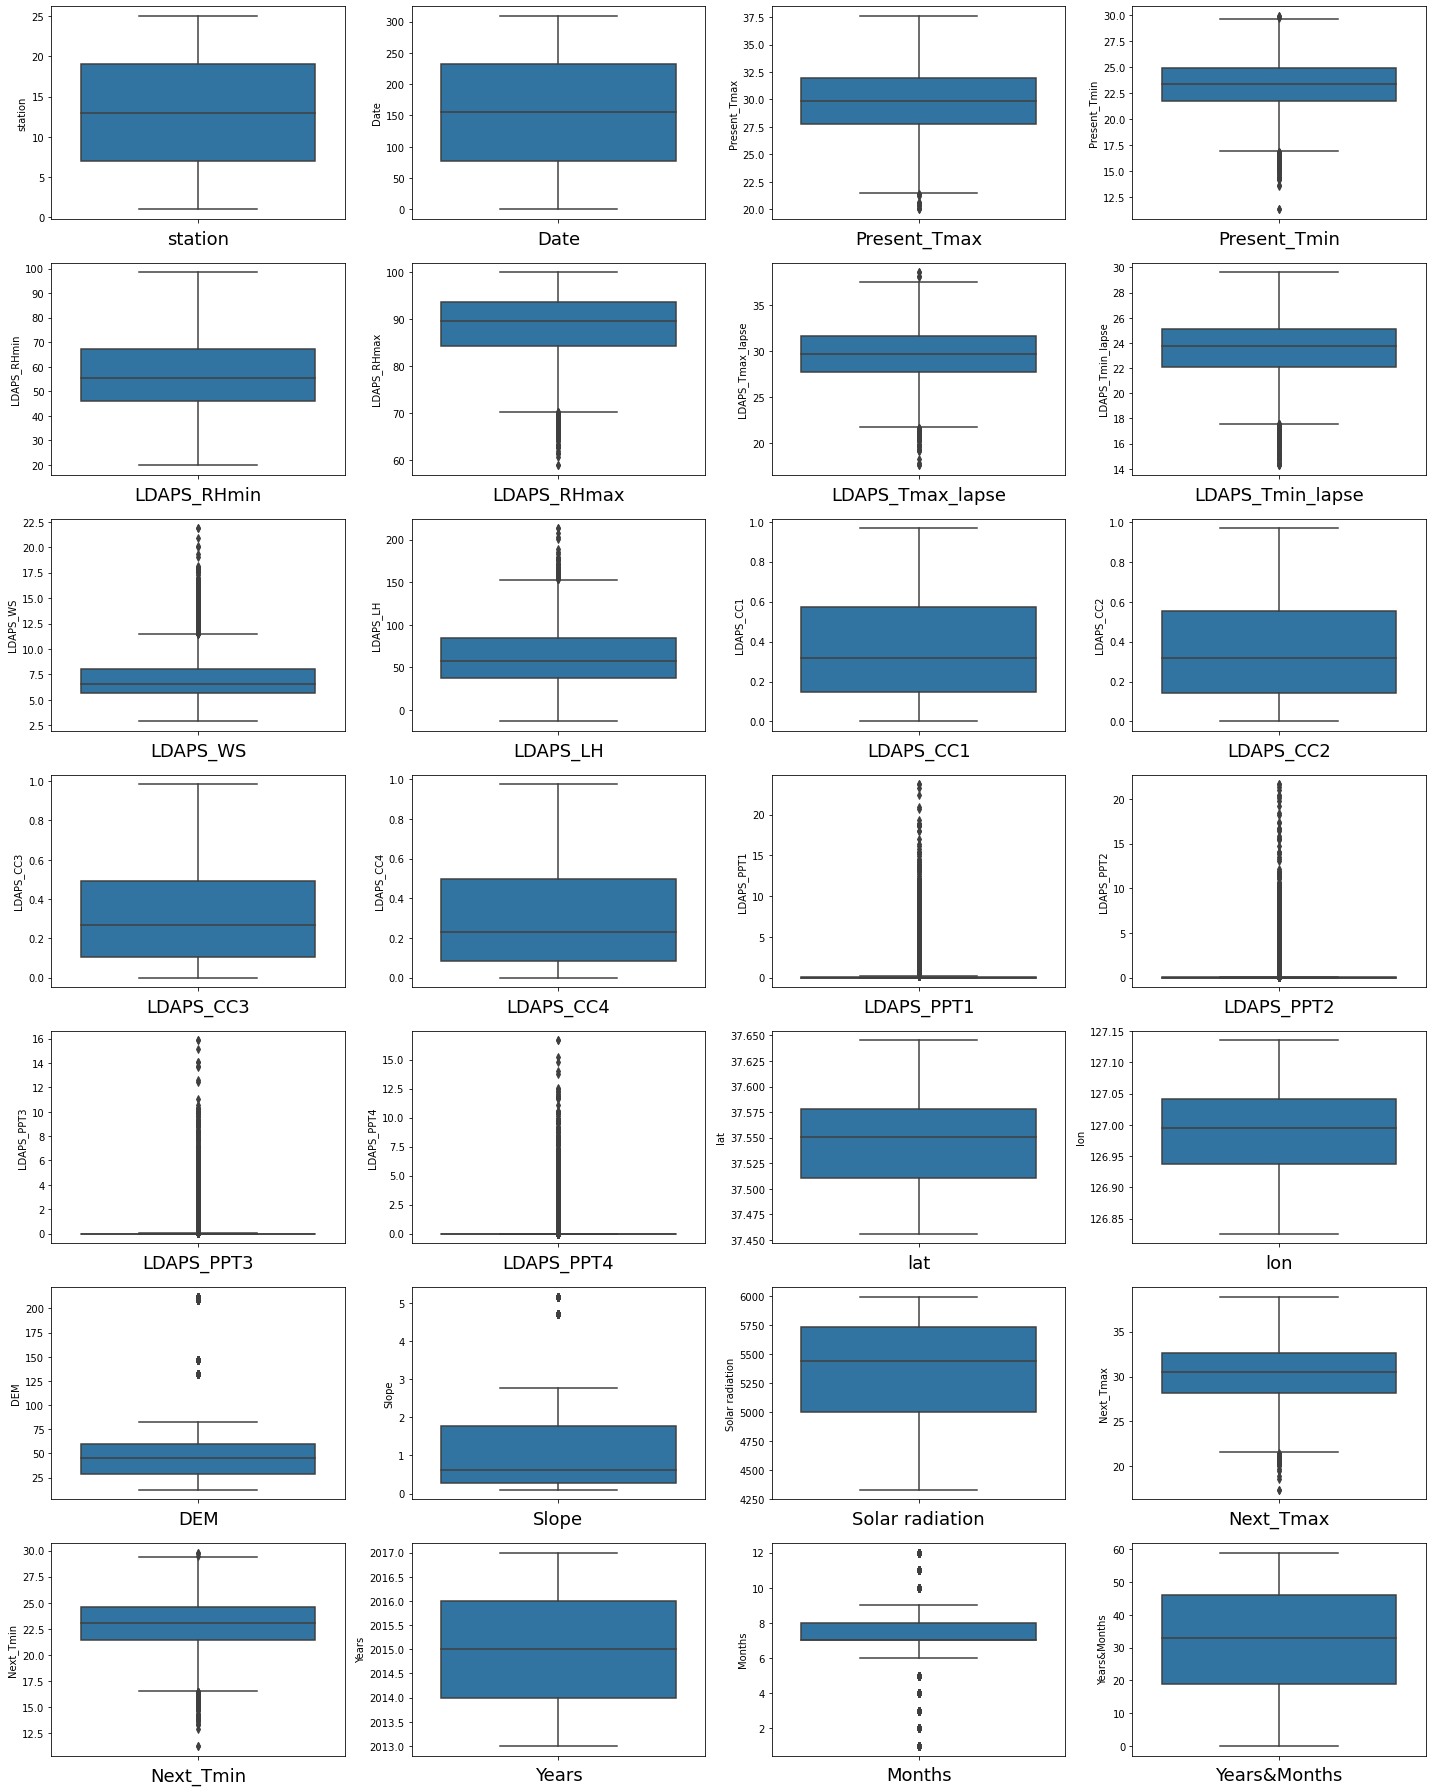

In [39]:
print('===========')
print('Box Plot :-')
print('===========')

plt.figure(figsize = (20,25), facecolor = 'white')
plotnumber = 1
for column in df:
    if plotnumber <=28:
        ax = plt.subplot(7,4, plotnumber)
        sns.boxplot(y=df[column]) # It is the axis for vertical set as y
        plt.xlabel(column, fontsize = 18)
    plotnumber += 1
plt.tight_layout()

#### There are outliers presents in dataset

### Removing Outliers

In [40]:
# with std 3 Lets see the stats

z_score = zscore(df[['LDAPS_Tmin_lapse', 'LDAPS_Tmax_lapse', 'Present_Tmin', 'Present_Tmax', 'Slope', 'DEM','LDAPS_PPT4', 'LDAPS_PPT3', 'LDAPS_PPT2','LDAPS_PPT1','LDAPS_LH','LDAPS_WS','LDAPS_RHmax']]) # use only continous data
abs_z_score = np.abs(z_score)

filtering_entry = (abs_z_score < 3).all(axis = 1)

df = df[filtering_entry]
df.describe()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Years,Months,Years&Months
count,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000,6907.000000
mean,13.033300,154.235558,29.931282,23.302013,55.583421,88.088971,29.878275,23.640180,6.866145,62.031957,0.345246,0.331271,0.293826,0.276273,0.317192,0.210192,0.105101,0.087952,37.543941,126.990896,61.136472,1.239104,5340.009071,30.557184,23.068685,2014.994354,7.092225,31.813088
std,7.197559,88.742729,2.858598,2.314743,13.831826,6.914275,2.736471,2.227762,1.839158,33.252717,0.250648,0.239761,0.230087,0.234575,0.916044,0.740502,0.395817,0.361225,0.050023,0.079661,53.566807,1.352191,420.898548,2.935480,2.379260,1.399536,2.242930,17.007075
min,1.000000,0.000000,21.200000,16.100000,19.794666,66.989464,21.195428,16.558304,2.882580,-8.569043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098500,4371.684570,20.800000,13.300000,2013.000000,1.000000,0.000000
25%,7.000000,77.000000,28.100000,21.700000,45.672770,83.927235,28.017782,22.212022,5.627930,36.724976,0.137903,0.133758,0.097375,0.078550,0.000000,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,5016.055176,28.600000,21.500000,2014.000000,7.000000,19.000000
50%,13.000000,155.000000,30.000000,23.400000,54.305267,89.179153,29.893167,23.830059,6.459767,57.243308,0.297931,0.297809,0.247877,0.211574,0.000000,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5428.586426,30.700000,23.200000,2015.000000,7.000000,33.000000
75%,19.000000,230.000000,32.100000,24.900000,65.023258,93.405521,31.800830,25.191881,7.733245,84.178826,0.500745,0.511272,0.451872,0.455960,0.023385,0.006099,0.002287,0.000000,37.577600,127.042000,59.832400,1.767800,5716.302246,32.700000,24.700000,2016.000000,8.000000,46.000000
max,25.000000,309.000000,37.600000,29.900000,96.169815,99.999008,38.140534,29.619342,13.589191,161.661149,0.967277,0.968353,0.971772,0.956348,6.381667,5.743190,3.720154,3.789353,37.645000,127.135000,212.335000,5.178200,5992.895996,38.900000,29.800000,2017.000000,12.000000,59.000000


Box Plot :-


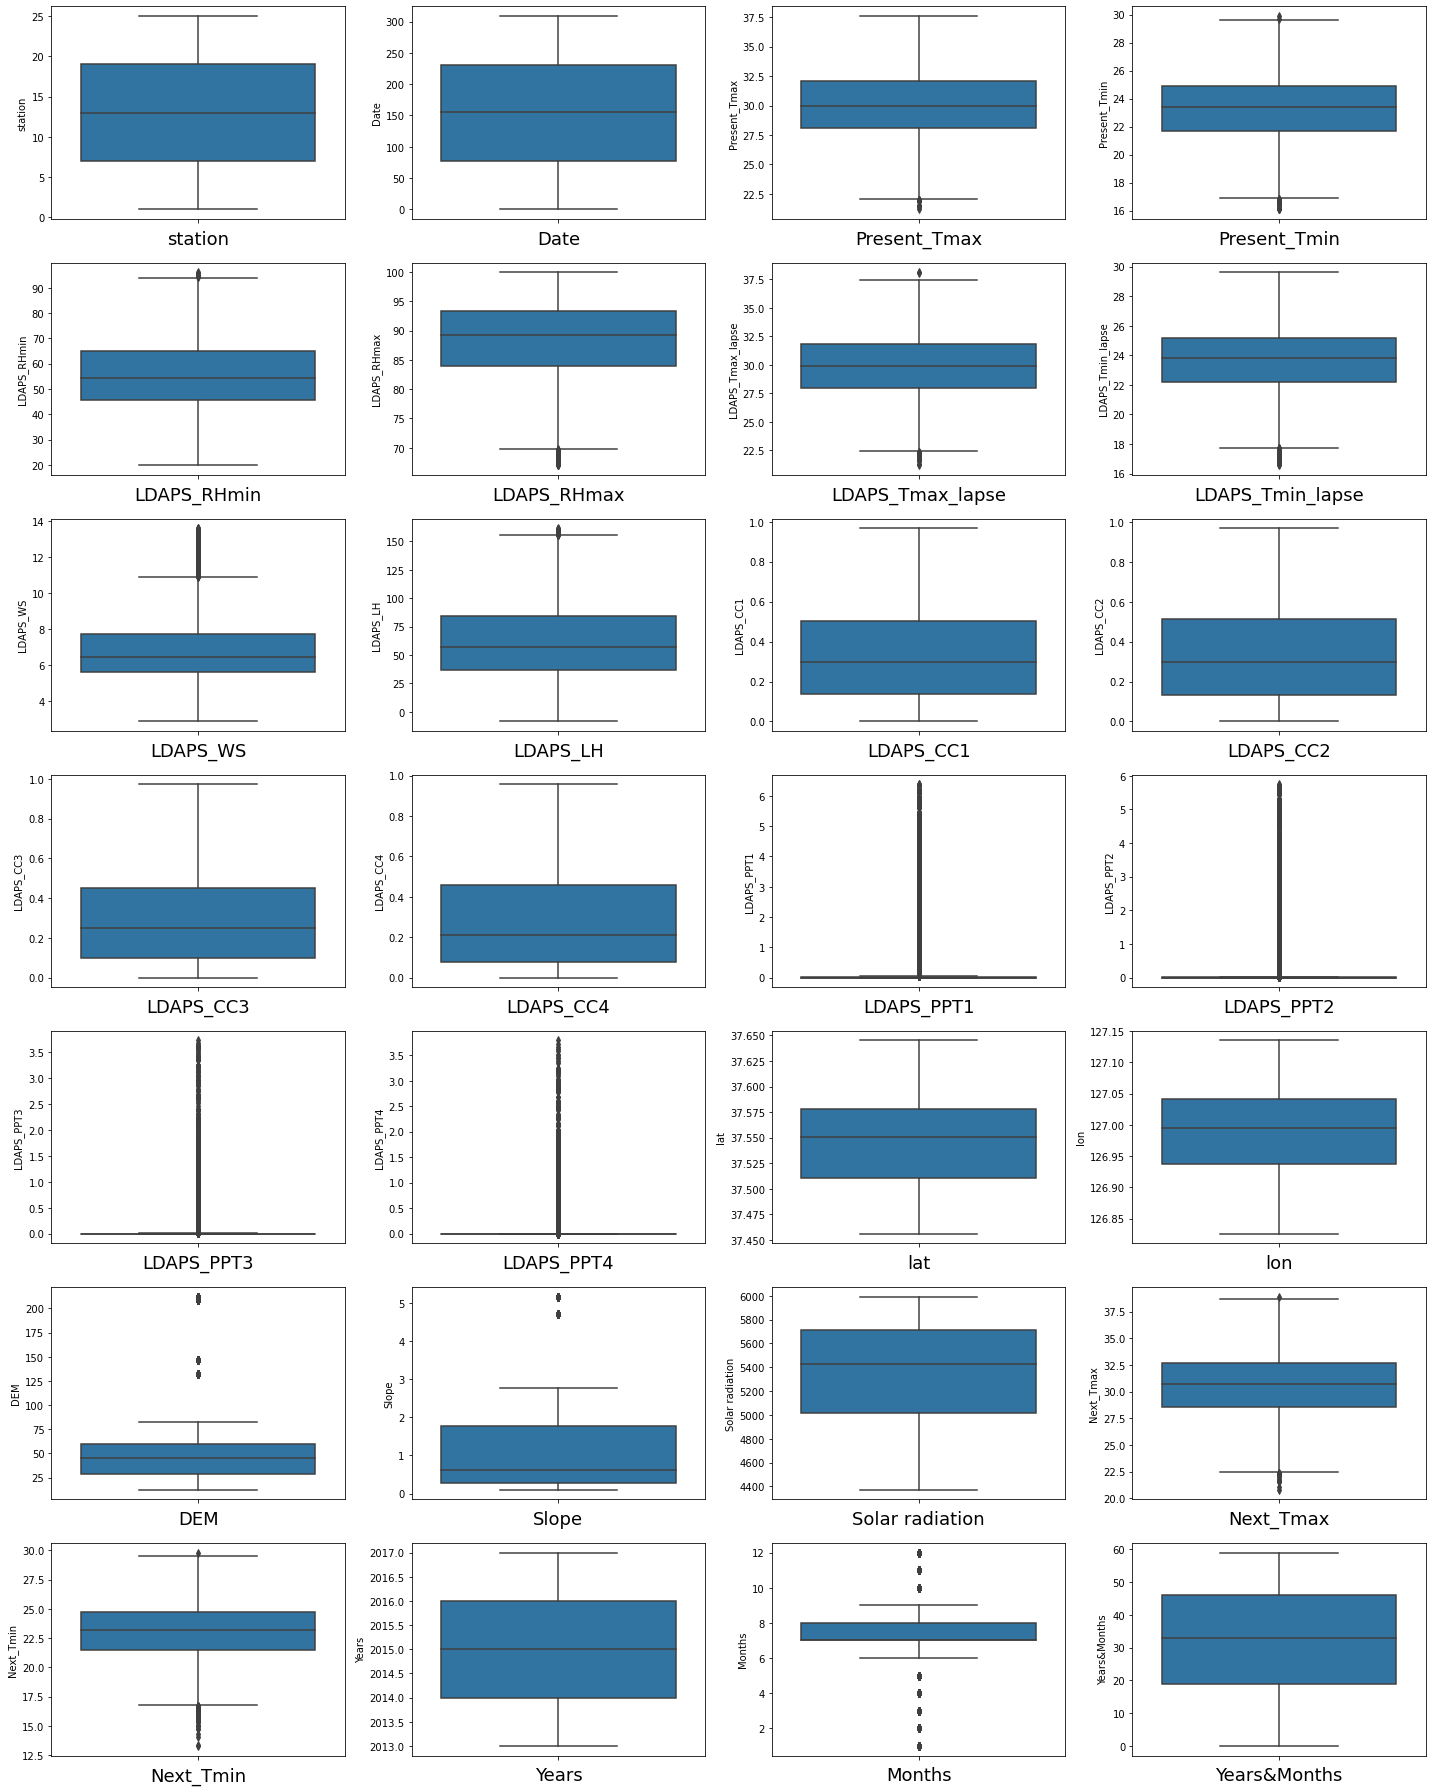

In [41]:
# Let' see outliers are removed in columns or not.
print('===========')
print('Box Plot :-')
print('===========')

plt.figure(figsize = (20,25), facecolor = 'white')
plotnumber = 1
for column in df:
    if plotnumber <=28:
        ax = plt.subplot(7,4, plotnumber)
        sns.boxplot(y=df[column]) # It is the axis for vertical set as y
        plt.xlabel(column, fontsize = 18)
    plotnumber += 1
plt.tight_layout()

In [42]:
df.shape # Here we check shape of remaining data after removal of outliers.

(6907, 28)

#### Outliers are removed

### Spliting Dataset into features and label

In [43]:
x = df.drop('Next_Tmin', axis = 1)
y = df. Next_Tmin
print('Data has been splited')

Data has been splited


-----------------
Scatter Plot :-
-----------------


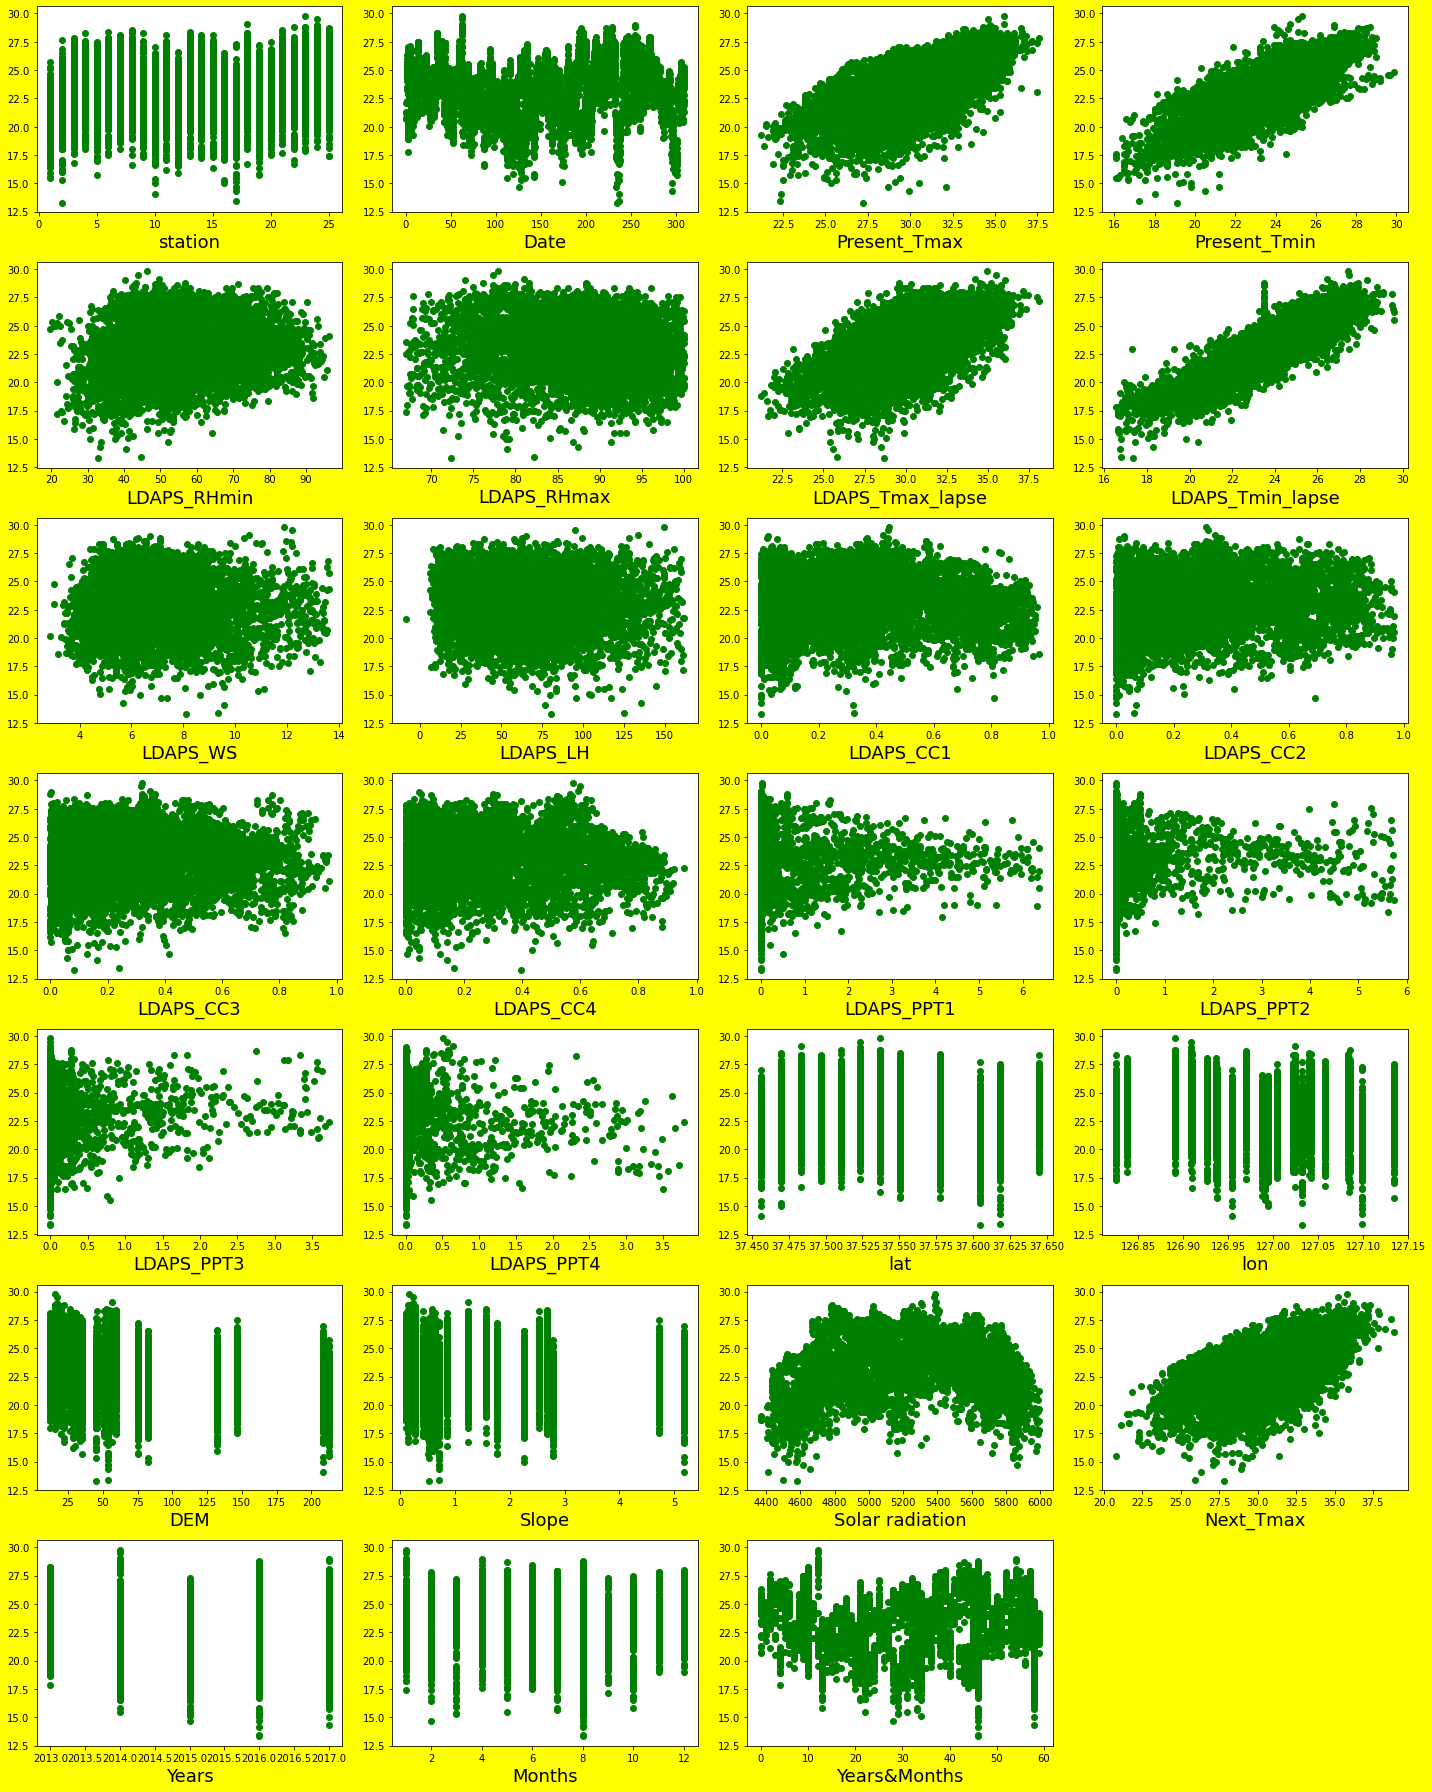

In [44]:
# Let' see relation between features and label.
print('-----------------')
print('Scatter Plot :-')
print('-----------------')

plt.figure(figsize = (20,25), facecolor = 'yellow')
plotnumber = 1
for column in x:
    if plotnumber <=28:
        ax = plt.subplot(7,4, plotnumber)
        plt.scatter(x[column],y, c = 'g')
        plt.xlabel(column, fontsize = 18)
    plotnumber += 1
plt.tight_layout()

#### Positive relation in feature and label

### Data Scaling

In [45]:
df.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Years,Months,Years&Months
0,1.0,12.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,2013,6,8.0
1,2.0,12.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,2013,6,8.0
2,3.0,12.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,0.0,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9,2013,6,8.0
3,4.0,12.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.0,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3,2013,6,8.0
4,5.0,12.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.0,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5,2013,6,8.0


In [46]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled

array([[0.        , 0.03883495, 0.45731707, ..., 0.        , 0.45454545,
        0.13559322],
       [0.04166667, 0.03883495, 0.65243902, ..., 0.        , 0.45454545,
        0.13559322],
       [0.08333333, 0.03883495, 0.63414634, ..., 0.        , 0.45454545,
        0.13559322],
       ...,
       [0.91666667, 0.97411003, 0.12804878, ..., 1.        , 0.63636364,
        0.98305085],
       [0.95833333, 0.97411003, 0.12804878, ..., 1.        , 0.63636364,
        0.98305085],
       [1.        , 0.97411003, 0.12195122, ..., 1.        , 0.63636364,
        0.98305085]])

### Split data into train and test. Model will be bulit on training data and tested on test data

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 355)
print('Data has been splited.')

Data has been splited.


### Model Building

### Decision Tree model instantiaing, training and evaluating

In [48]:
bag_dt = BaggingRegressor(DecisionTreeRegressor(), n_estimators = 15, max_samples = 0.5, bootstrap = True,
                          random_state= 3, oob_score = True)

In [49]:
bag_dt.oob_score

True

In [50]:
bag_dt.fit(x_train, y_train)
print('Bagging DT score ------->', bag_dt.score(x_test, y_test))

Bagging DT score -------> 0.881936042407601


In [51]:
y_pred = bag_dt.predict(x_test)

In [52]:
print('=========================================================')
print('R2 Score ----->', r2_score(y_test, y_pred))
print('=========================================================')
print('RMSE of Model ------->', np.sqrt(mean_squared_error(y_test, y_pred)))
print('=========================================================')
print('MSE of Model ------->', mean_squared_error(y_test, y_pred))
print('=========================================================')
print('Score of test data ---->', bag_dt.score(x_test, y_test))
print('=========================================================')

R2 Score -----> 0.881936042407601
RMSE of Model -------> 0.8229614948083417
MSE of Model -------> 0.6772656219371802
Score of test data ----> 0.881936042407601


#### Conclusion : Decision Tree model has 88% score

### Xgboost model instantiaing, training and evaluating

In [53]:
bag_xgb = BaggingRegressor(xgb.XGBRegressor(eval_metric = 'mlogloss'), n_estimators = 30, max_samples = 0.5, bootstrap = True,
                          random_state= 3, oob_score = True)

In [54]:
bag_xgb.oob_score

True

In [55]:
bag_xgb.fit(x_train, y_train)
print('Bagging XGBoost score ------->', bag_xgb.score(x_test, y_test))

Bagging XGBoost score -------> 0.9304298762527333


In [56]:
y_pred = bag_xgb.predict(x_test)

In [57]:
print('=========================================================')
print('R2 Score ----->', r2_score(y_test, y_pred))
print('=========================================================')
print('RMSE of Model ------->', np.sqrt(mean_squared_error(y_test, y_pred)))
print('=========================================================')
print('MSE of Model ------->', mean_squared_error(y_test, y_pred))
print('=========================================================')
print('Score of test data ---->', bag_xgb.score(x_test, y_test))
print('=========================================================')

R2 Score -----> 0.9304298762527333
RMSE of Model -------> 0.6317310671849325
MSE of Model -------> 0.39908414124661373
Score of test data ----> 0.9304298762527333


### Conclusion : XGBoost model has 93% score

### Knn model instantiaing, training and evaluating

In [58]:
bag_Knn = BaggingRegressor(KNeighborsRegressor(n_neighbors = 5), n_estimators = 30, max_samples = 0.5, bootstrap = True,
                          random_state= 3, oob_score = True)

In [59]:
bag_Knn.oob_score

True

In [60]:
bag_Knn.fit(x_train, y_train)
print('Bagging KNN score ------->', bag_Knn.score(x_test, y_test))

Bagging KNN score -------> 0.7599901059442604


In [61]:
y_pred = bag_Knn.predict(x_test)

In [62]:
print('=========================================================')
print('R2 Score ----->', r2_score(y_test, y_pred))
print('=========================================================')
print('RMSE of Model ------->', np.sqrt(mean_squared_error(y_test, y_pred)))
print('=========================================================')
print('MSE of Model ------->', mean_squared_error(y_test, y_pred))
print('=========================================================')
print('Score of test data ---->', bag_Knn.score(x_test, y_test))
print('=========================================================')

R2 Score -----> 0.7599901059442604
RMSE of Model -------> 1.173371187528214
MSE of Model -------> 1.3767999437213714
Score of test data ----> 0.7599901059442604


#### Conclusion : Knn model has 75% score

### Random Forest model instantiaing, training and evaluating

In [63]:
bag_Rn = BaggingRegressor(RandomForestRegressor(), n_estimators = 30, max_samples = 0.5, bootstrap = True,
                          random_state= 3, oob_score = True)

In [64]:
bag_Rn.oob_score

True

In [65]:
bag_Rn.fit(x_train, y_train)
print('Bagging Random Forest score ------->', bag_Rn.score(x_test, y_test))

Bagging Random Forest score -------> 0.8839390752176481


In [66]:
y_pred = bag_Rn.predict(x_test)

In [67]:
print('=========================================================')
print('R2 Score ----->', r2_score(y_test, y_pred))
print('=========================================================')
print('RMSE of Model ------->', np.sqrt(mean_squared_error(y_test, y_pred)))
print('=========================================================')
print('MSE of Model ------->', mean_squared_error(y_test, y_pred))
print('=========================================================')
print('Score of test data ---->', bag_Rn.score(x_test, y_test))
print('=========================================================')

R2 Score -----> 0.8839390752176481
RMSE of Model -------> 0.8159505895222902
MSE of Model -------> 0.6657753645417729
Score of test data ----> 0.8839390752176481


#### Conclusion : Random Forest model has 88% score

### Linear Regression model instantiaing, training and evaluating

In [68]:
bag_Lr = BaggingRegressor(LinearRegression(), n_estimators = 30, max_samples = 0.5, bootstrap = True,
                          random_state= 3, oob_score = True)

In [69]:
bag_Lr.oob_score

True

In [70]:
bag_Lr.fit(x_train, y_train)
print('Bagging Linear Regression score ------->', bag_Lr.score(x_test, y_test))

Bagging Linear Regression score -------> 0.8298079188960044


In [71]:
y_pred = bag_Lr.predict(x_test)

In [72]:
print('=========================================================')
print('R2 Score ----->', r2_score(y_test, y_pred))
print('=========================================================')
print('RMSE of Model ------->', np.sqrt(mean_squared_error(y_test, y_pred)))
print('=========================================================')
print('MSE of Model ------->', mean_squared_error(y_test, y_pred))
print('=========================================================')
print('Score of test data ---->', bag_Lr.score(x_test, y_test))
print('=========================================================')

R2 Score -----> 0.8298079188960044
RMSE of Model -------> 0.988076389103983
MSE of Model -------> 0.9762949507047656
Score of test data ----> 0.8298079188960044


#### Conclusion : Linear Regression model has 82% score

### Looking RMSE we found XGBoost has best model so we do Hyperparameter Tuning on it

In [74]:
param = {'n_estimators': [50,100], 'max_samples': [1.0], 'bootstrap': [True]}

In [75]:
grid_search = GridSearchCV(estimator = bag_xgb, param_grid = param, cv = 5 , n_jobs = -1)

In [76]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(base_estimator=XGBRegressor(base_score=None,
                                                                    booster=None,
                                                                    colsample_bylevel=None,
                                                                    colsample_bynode=None,
                                                                    colsample_bytree=None,
                                                                    eval_metric='mlogloss',
                                                                    gamma=None,
                                                                    gpu_id=None,
                                                                    importance_type='gain',
                                                                    interaction_constraints=None,
                                                                    learning_rate=None,
         

In [77]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'bootstrap': True, 'max_samples': 1.0, 'n_estimators': 100}


In [78]:
hxgb = BaggingRegressor(base_estimator=xgb.XGBRegressor(eval_metric = 'mlogloss'),max_samples = 1.0, bootstrap = True , n_estimators = 100)
hxgb.fit(x_train, y_train)
hxgb.score(x_test, y_test)

0.94111442947522

In [79]:
y_pred = hxgb.predict(x_test)

In [80]:
print('=========================================================')
print('R2 Score ----->', r2_score(y_test, y_pred))
print('=========================================================')
print('RMSE of Model ------->', np.sqrt(mean_squared_error(y_test, y_pred)))
print('=========================================================')
print('MSE of Model ------->', mean_squared_error(y_test, y_pred))
print('=========================================================')
print('Score of test data ---->', bag_Lr.score(x_test, y_test))
print('=========================================================')

R2 Score -----> 0.94111442947522
RMSE of Model -------> 0.5811995786096222
MSE of Model -------> 0.3377929501760024
Score of test data ----> 0.8298079188960044


#### After Hyperparameter Tuning model accuracy score 94%.

### Saving The Model

In [81]:
# saving the model to the Local file system
filename = 'Temperature Forecast Project (Next  Day Minimum  Air Temperatures).pickle'
pickle.dump(hxgb, open(filename, 'wb'))

### Predict Temperature Forecast Project (Next  Day Maximum  Air Temperatures)

In [82]:
model = pickle.load(open('Temperature Forecast Project (Next  Day Minimum  Air Temperatures).pickle', 'rb'))
result = model.score(x_test, y_test)
print('Predicted Score --------->', result)

Predicted Score ---------> 0.94111442947522


In [83]:
Prediction = pd.DataFrame([model.predict(x_test)[:], y_test[:]], index = ['Predicted', 'Orginal'])
Prediction

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

### Saving the predicted result in CSV file

In [85]:
Prediction.to_csv('Temperature Forecast Project (Next  Day Minimum  Air Temperatures).csv')

## Final Conclusion : XGBoost is our best model.